In [29]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [39]:
# Animals names dataset

with open('animals_names.txt', 'r') as file:
    data = file.read()

# Split the data into a list of names
words = [name.lower() for name in data.split(',')]

# Print the list to verify
print(words[:10])

for w in words:
    if "'" in w or "-" in w or "(" in w or ")" in w:
        words.remove(w)

['canidae', 'felidae', 'cat', 'cattle', 'dog', 'donkey', 'goat', 'guineapig', 'horse', 'pig']


In [35]:
all_names_string = ''.join(words)

# Create a set of unique characters
unique_characters = set(all_names_string)

# Print the unique characters
print(unique_characters)

{'q', 'v', 'i', "'", 'x', 'h', 'a', 'p', 'j', 'o', 'f', 'b', 'e', 'y', 's', 'd', 'c', 'u', 'w', 't', 'k', '-', '(', 'm', 'r', 'l', 'n', 'z', ')', 'g'}


In [31]:
# People names dataset
# words = open("names.txt", 'r').read().splitlines()
# words[:10]

In [40]:
# Vocabulary
chars = [c for c in '.abcdefghijklmnopqrstuvwxyz']

# Convertion between characters and integers
itos = {i: c for i, c in enumerate(chars)}
stoi = {c: i for i, c in enumerate(chars)}

In [41]:
block_size = 3
def build_dataset(names):
    X, Y = [], []

    for name in names:
        c1 = [0] * block_size
        for ch in name + '.':
            X.append(c1)
            Y.append(stoi[ch])
            c1 = c1[1:] + [stoi[ch]]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)

    return X, Y

In [42]:
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([18174, 3]) torch.Size([18174])
torch.Size([2271, 3]) torch.Size([2271])
torch.Size([2292, 3]) torch.Size([2292])


In [43]:
n_emb = 10 # dimension of embeddings
n_hidden = 200 # number of neurons on the hidden layer
vocab_size = len(chars) # size of the vocabulary

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_emb), generator=g)
W1 = torch.randn((n_emb*block_size, n_hidden), generator=g)
b1 = torch.randn((n_hidden), generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g)
b2 = torch.randn((vocab_size), generator=g)
parameters = [C, W1, b1, W2, b2]

In [44]:
# Number of parameters
print(sum(p.numel() for p in parameters), "parameters")
for p in parameters:
    p.requires_grad = True

11897 parameters


In [45]:
max_steps = 200000
batch_size = 32
losses = []

for i in range(max_steps):    
    
    #mini batch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    #Forward pass
    emb = C[Xb]
    hidden_state = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1)
    logits = hidden_state @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data -= p.grad * lr

    losses.append(loss.log10().item())


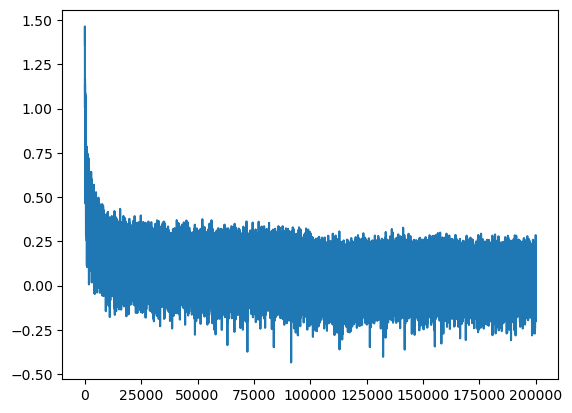

In [46]:
plt.plot(losses)

In [47]:
# Calculate loss on validation set
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'dev': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x]
    hidden_state = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1)
    logits = hidden_state @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(f'{split} loss: {loss.item()}')

split_loss('train')
split_loss('dev')

train loss: 1.166662335395813
dev loss: 1.5019720792770386


In [49]:
g = torch.Generator().manual_seed(14)

for _ in range(15):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, 1)
        ix = torch.multinomial(probs, 1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join([itos[i] for i in out[:-1]]))

mountainu
chesapeafowlandicoot
wildentlesnail
her
squirt
list
uguese
wildebeetle
devil
sun
penguin
dragon
angerbil
saine
thrus
